In [1]:
import tensorflow as tf
import keras
# importing of modules for LeNet CNN 
from keras import backend as K
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense, Dropout
from keras.datasets import mnist
from keras.utils import np_utils, to_categorical
from keras.optimizers import SGD, RMSprop, Adam

# importing of service libraries
import numpy as np
import matplotlib.pyplot as plt

print('Libraries imported.')

import csv
import os
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
#os.chdir(os.path.dirname(os.path.abspath(__file__)))

from pathlib import Path

from mydir.get_line_ids import get_line_ids
from mydir.get_line_stats import get_line_stats
from mydir.gen2tensor import gen2tensor
from mydir.get_species import get_species_tree
#from mydir.plot_processing import plot_tree, plot_heatmap
from mydir.NaiveBayes import NaiveBayes

Libraries imported.


In [2]:
path = os.getcwd()
parent = os.path.dirname(path)

TREEFILE = parent + "\mydir\insect.csv"
SEQFILE = parent + "\mydir\line_ids.json"
      
import json

with open(SEQFILE,encoding='utf-8-sig', errors='ignore') as f: 
      line_ids = json.load(f, strict=False)


In [3]:
# Loading and Pre processing 
reduced_tree_df = pd.read_csv(TREEFILE, index_col="BOLD_ID")

reduced_tree_df.reset_index(inplace=True)
reduced_tree_df = reduced_tree_df[~reduced_tree_df["Species"].str.contains('sp\.$', na=False, regex=True)]
vc = reduced_tree_df["Species"].value_counts()
mutiple_sample_species = vc[vc > 40].index.values.tolist()
reduced_tree_df = reduced_tree_df[reduced_tree_df["Species"].isin(mutiple_sample_species)]
reduced_tree_df = reduced_tree_df.set_index("BOLD_ID")

insect_df = reduced_tree_df[reduced_tree_df["Class"] == "Insecta"]

In [4]:
taxa = insect_df["Species"].dropna()

enc = OneHotEncoder(sparse=False, categories = [["A", "G", "T", "C", "-"]]*901)
to_encode = [list(line_ids[x]) for x in taxa.index]

encoded = enc.fit_transform(to_encode)
print(encoded.shape)

encoded = np.reshape(encoded, (len(taxa), 901, 5))

# Reduce the tensor length from 5 to 4, gap characters are now [0,0,0,0]
encoded4 = []
for species in encoded:
    species = species[1:]
    encoded4.append([row[:-1] for row in species])

encoded4 = np.reshape(encoded4, (len(taxa), 900, 4, 1))
print(encoded4.shape)

(328, 4505)
(328, 900, 4, 1)


In [5]:
# network and training parameters
N_EPOCH = 10 # later use more for better results
BATCH_SIZE = 128
VERBOSE = 1
OPTIMIZER = Adam(lr=0.001)
VALIDATION_SPLIT=0.2
P_DROPOUT1 = 0.3
P_DROPOUT2 = 0.1


INPUT_SHAPE = (900, 4, 1)
N_CLASSES = len(set(taxa))
N_HIDDEN = 2/3*(900+N_CLASSES)

In [17]:
#define the convnet 
class ConNet:
	@staticmethod
	def build(input_shape, classes, p_dropout1, p_dropout2, n_hidden):
		model = Sequential()
        
		# CONV => RELU => POOL
		model.add(Conv2D(20, kernel_size=2, padding="same", strides=(2,2), input_shape=input_shape))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), data_format='channels_last'))
		model.add(Dropout(p_dropout1))
        
		# CONV => RELU => POOL
		model.add(Conv2D(50, kernel_size=2, padding="same"))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding= "same", data_format='channels_last'))
		model.add(Dropout(p_dropout2))
        
		# Flatten => RELU layers
		model.add(Flatten())
		model.add(Dense(n_hidden))
		model.add(Activation("relu"))
 
		# a softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		return model

print('ConNet class defined.')

ConNet class defined.


In [18]:
# train test split
taxa_encoded = to_categorical(np.asarray(taxa.factorize()[0]), N_CLASSES)

x_train, x_test, y_train, y_test, y_train_label, y_test_label = train_test_split(encoded4, taxa_encoded, taxa, test_size=0.30, random_state=21, stratify=taxa_encoded)
# Need to alter the test size so that the proportion after augmentation is around 70:30 ???

augment_data_flag = True
loops = 3
changes = 5

if(augment_data_flag):
    # DATA AUGEMENTATION
    for loop in range(0,loops):
        aug = []
        for seq in x_train:
            for i in range(0, changes):
                rand_id = random.randint(0, 899) #Choose a position to mutate
                while True:
                    rand_char = random.randint(0, 3) #"A", "G", "C", "T"

                    new_list = np.array([[0],[0],[0],[0]])
                    new_list[rand_char] = [1]

                    if seq[rand_id][rand_char] != new_list[rand_char]: break

                seq[rand_id] = new_list
            aug.append(seq)

        aug = np.array(aug)

        x_train = np.append(x_train, aug, axis=0)
        y_train = np.append(y_train, y_train, axis=0)


In [19]:
# initialize the optimizer and compile the model
model = ConNet.build(input_shape=INPUT_SHAPE, classes=N_CLASSES, p_dropout1=P_DROPOUT1, p_dropout2=P_DROPOUT2, n_hidden=N_HIDDEN)

model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER, metrics=["accuracy"])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 450, 2, 20)        100       
_________________________________________________________________
activation_12 (Activation)   (None, 450, 2, 20)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 225, 1, 20)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 225, 1, 20)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 225, 1, 50)        4050      
_________________________________________________________________
activation_13 (Activation)   (None, 225, 1, 50)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 113, 1, 50)       

In [16]:
# training/fitting of the LeNet model
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=1, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)


12/12 [==============================] - 70s 6s/step - loss: 1.8179 - accuracy: 0.5065 - val_loss: 0.9452 - val_accuracy: 0.5668


In [25]:
score = model.evaluate(x_test, y_test, verbose=VERBOSE)
print("\nTest score/loss:", score[0])
print('Test accuracy:', score[1])

# syntetic data, stratified, dense layer, test accuracy
row = [0, True, True, score[1], "back to 70:30", ">40"]

# open the file in the write mode
with open('CNNout.csv', 'a') as f:
    # create the csv writer
    writer = csv.writer(f)

    # write a row to the csv file
    writer.writerow(row)

4/4 [==============================] - 0s 62ms/step - loss: 0.1571 - accuracy: 0.9798

Test score/loss: 0.15705041587352753
Test accuracy: 0.9797979593276978


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


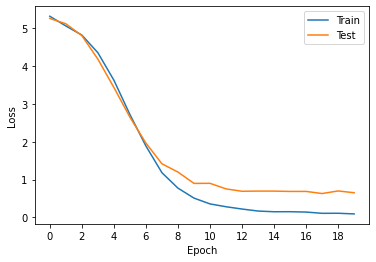

In [88]:
# list all data in history
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(0, 20, 2))
plt.legend(['Train', 'Test'], loc='upper right')

plt.savefig("CNN_loss.png")
plt.show()

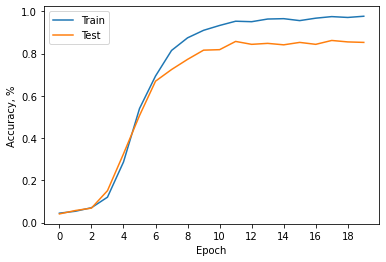

In [89]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy, %')
plt.xlabel('Epoch')
plt.xticks(np.arange(0, 20, 2))
plt.legend(['Train', 'Test'], loc='upper left')

plt.savefig("CNN_accuracy.png")
plt.show()

In [105]:
# Which species are poorly classified

from sklearn.metrics import multilabel_confusion_matrix
labels=y_test_label.unique()
mlcm = multilabel_confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(x_test), axis=1))

index = 0
score_arr = []
for cm in mlcm:
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp/(fn+tp)
    precision = tp/(tp+fp)
    accuracy = (tp+fn)/(tn+fp+fn+tp)
    score_arr = score_arr + [[labels[index], sensitivity, precision, accuracy]]
    
    index = index+1

score_df = pd.DataFrame(score_arr, columns = ["Species", "Sensitivity", "Precision", "Accuracy"])

lowest_sens = score_df.nsmallest(10, 'Sensitivity')
lowest_prec = score_df.nsmallest(10, 'Precision')
#print(lowest_sens)
#print(lowest_sens["Species"].values)
#print(lowest_prec)
#print(lowest_prec["Species"].values)
#print(score_df[score_df["Sensitivity"]<1]["Species"].values)
print(score_df["Sensitivity"].to_list())

[1.0, 0.8888888888888888, 1.0, 0.07692307692307693]


In [12]:
# Parameter tuning
for N_HIDDEN in [400,600, 800, 1000]:
    model = ConNet.build(input_shape=INPUT_SHAPE, classes=N_CLASSES, p_dropout1=P_DROPOUT1, p_dropout2=P_DROPOUT2, n_hidden=N_HIDDEN)

    model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER, metrics=["accuracy"])

    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=2, verbose=0, validation_split=VALIDATION_SPLIT)

    score = model.evaluate(x_test, y_test, verbose=VERBOSE)

    print(N_HIDDEN)
    print('Test accuracy:', score[1])

35/35 [==============================] - 3s 82ms/step - loss: 0.4391 - accuracy: 0.8881
400
Test accuracy: 0.8880733847618103
35/35 [==============================] - 4s 115ms/step - loss: 0.4619 - accuracy: 0.8807
600
Test accuracy: 0.8807339668273926


KeyboardInterrupt: 